# Modeling the Data Using Transfer Learning with ULMFiT

In [1]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [2]:
full_df = pd.read_csv('data/clinic_train_data.csv', index_col=0)
full_df.head(3)

,subject_id,hadm_id,admission_time,discharge_time,next_admission,days_between_admit,admission_type,time_of_death,text,readmission
0,60476,106006,2198-06-12 08:00:00,2198-06-29 13:00:00,NaN,NaN,EMERGENCY,NaN,Admission Date: [**2198-6-12**] ...,0
2,5928,140311,2153-09-02 22:31:00,2153-09-14 18:25:00,NaN,NaN,EMERGENCY,NaN,Admission Date: [**2153-9-2**] D...,0
3,11003,163654,2123-03-01 23:30:00,2123-03-10 15:24:00,NaN,NaN,EMERGENCY,NaN,Admission Date: [**2123-3-1**] D...,0


In [3]:
full_df.shape

(35779, 10)

In [4]:
df = full_df[['readmission','text']].copy()
df.columns = ['label', 'text']
df = df.reset_index(drop = True)
df.head(3)

,label,text
0,0,Admission Date: [**2198-6-12**] ...
1,0,Admission Date: [**2153-9-2**] D...
2,0,Admission Date: [**2123-3-1**] D...


In [5]:
df['label'].value_counts()

0    33625
1     2154
Name: label, dtype: int64

In [6]:
# replace non-alphabetic character
df['text'] = df['text'].str.replace("[^a-zA-Z]", " ")

In [7]:
# define stopwords
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords 
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# tokenization 
tokenized_doc = df['text'].apply(lambda x: x.split())

# remove stop-words 
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization 
detokenized_doc = [] 
for i in range(len(df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

df['text'] = detokenized_doc

In [9]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df, 
                                  stratify = df['label'], 
                                  test_size = 0.33, 
                                  random_state = 42)

In [10]:
df_trn.shape, df_val.shape

((23971, 2), (11808, 2))

In [11]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, 
                                  valid_df = df_val, 
                                  path = "",
                                  chunksize=500)

In [12]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", 
                                      train_df = df_trn, 
                                      valid_df = df_val, 
                                      vocab=data_lm.train_ds.vocab, 
                                      bs=16)

In [ ]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.7)

In [14]:
# train the learner object with learning rate = 1e-2
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,3.708642,3.440692,0.427631


In [ ]:
learn.save_encoder('ft_enc')

In [13]:
learn = text_classifier_learner(data_clas, drop_mult=0.7)
learn.load_encoder('ft_enc')

In [15]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.262370,0.228537,0.939702


In [16]:
# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1
row_0,,
0,11095,710
1,2,1


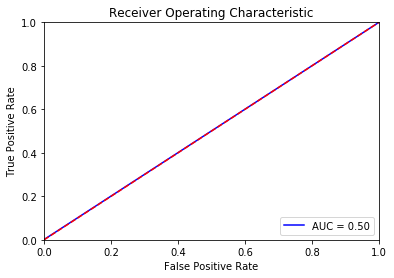

In [27]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(targets.numpy(), predictions)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()